<a href="https://colab.research.google.com/github/chi-yan/notebooks/blob/master/Bible_Sentiment_Analysis_with_NLP_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2021-10-17 03:06:46--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2021-10-17 03:06:46--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2021-10-17 03:06:47--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:44

In [2]:
import pandas as pd
import numpy as np
import json
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp
from sparknlp.pretrained import PretrainedPipeline

In [3]:
spark = sparknlp.start()

In [4]:
pipeline = PretrainedPipeline('analyze_sentimentdl_glove_imdb', lang = 'en')

analyze_sentimentdl_glove_imdb download started this may take some time.
Approx size to download 155.3 MB
[OK!]


In [5]:
import csv
!curl https://raw.githubusercontent.com/EswarGitHub/BibleSearch/master/bible_data_set.csv -o bible_data_set.csv
reader = csv.reader(open('bible_data_set.csv', 'r'))
d = {}
for row in reader:
  k,_,_,_,v = row
  d[k] = v[:-2] #  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5010k  100 5010k    0     0  10.5M      0 --:--:-- --:--:-- --:--:-- 10.4M


In [6]:
del d['citation'] #remove header row

In [25]:
d['Genesis 1:1']

'In the beginning God created the heaven and the earth.'

In [7]:
def convertVerseToBook(verse):
  if verse.split()[0] in ['1','2']:
    book = verse.split()[0] + ' ' + verse.split()[1]
  else:
    book = verse.split()[0]
  return(book)

In [8]:
verses = []
text = []

for verse in d:
  verses.append(verse)
  text.append(d[verse])


In [9]:
annotations =  pipeline.fullAnnotate(text)

In [29]:
len(sentiment)

31102

In [34]:
sentiment = []
for i in range(len(annotations)):
  sentiment.append(float(annotations[i]['sentiment'][0].metadata['pos']))

In [35]:
book = []
for verse in verses:
  book.append(convertVerseToBook(verse))

In [36]:
zippedList =  list(zip(verses, book, sentiment, text))

In [37]:
df =  pd.DataFrame(zippedList, columns = ['Verse' , 'Book', 'Sentiment', 'Text'])

In [38]:
df

,Verse,Book,Sentiment,Text
0,Genesis 1:1,Genesis,0.999998,In the beginning God created the heaven and th...
1,Genesis 1:2,Genesis,0.999997,"And the earth was without form, and void; and ..."
2,Genesis 1:3,Genesis,0.999994,"And God said, Let there be light: and there wa..."
3,Genesis 1:4,Genesis,0.999997,"And God saw the light, that it was good: and G..."
4,Genesis 1:5,Genesis,0.999999,"And God called the light Day, and the darkness..."
...,...,...,...,...
31097,Revelation 22:17,Revelation,0.999809,"And the Spirit and the bride say, Come. And le..."
31098,Revelation 22:18,Revelation,0.984770,For I testify unto every man that heareth the ...
31099,Revelation 22:19,Revelation,0.987182,And if any man shall take away from the words ...
31100,Revelation 22:20,Revelation,0.999988,"He which testifieth these things saith, Surely..."


In [48]:
pd.set_option('display.max_rows', 100)
results = df.groupby('Book')['Sentiment'].mean().sort_values(ascending=False)
print(results)

Book
2 John             0.997030
1 Chronicles       0.920554
Philemon           0.909425
Revelation         0.899109
2 Chronicles       0.896613
Daniel             0.882904
Philippians        0.877638
1 Kings            0.873048
Haggai             0.863092
1 Samuel           0.858588
Genesis            0.857403
Malachi            0.856458
Ezra               0.854315
2 Kings            0.850056
Zechariah          0.845642
Ephesians          0.842864
Joshua             0.837799
2 Samuel           0.833961
Esther             0.827044
Ruth               0.826732
Song               0.824418
3                  0.817267
Judges             0.812573
Numbers            0.811481
1 Thessalonians    0.802876
1 John             0.802708
Deuteronomy        0.801811
Ezekiel            0.800009
Colossians         0.796707
2 Timothy          0.794519
Joel               0.788077
Exodus             0.786656
Nehemiah           0.780769
1 Peter            0.778345
Jonah              0.775889
2 Thessalonians

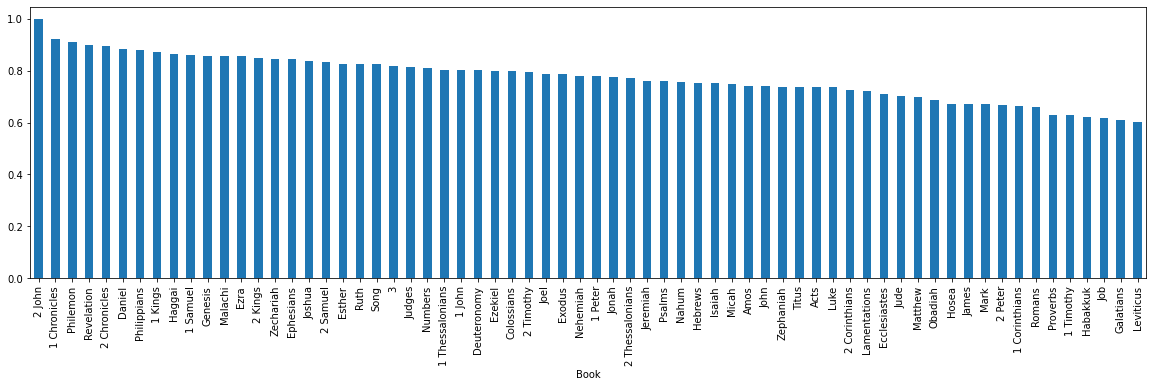

In [54]:
ax = results.plot.bar(x='Book',figsize=(20,5))